# Project: Analysis of Bank Stocks from US, Japan, and Hong Kong

## Introduction: 

* Background: 

Generally, interest rates and stock prices have an inverse relationship, as higher rates make future corporate earnings less valuable in today's terms and increase the cost of borrowing for companies. Additionally, rising interest rates can reduce consumer spending and make alternative investments like bonds more attractive, causing investors to shift capital away from stocks. This dynamic is more pronounced for growth stocks and interest-sensitive industries. However, the impact on specific sectors, like banking, can be different, as they may benefit from wider profit margins in a rising rate environment. Ultimately, the reason for the rate change and the overall economic context are crucial in determining the market's reaction.
Rising interest rates generally have a positive impact on bank stocks by increasing their Net Interest Margin (NIM), which is the core measure of their profitability. This occurs because banks can charge more for new loans while the interest they pay on deposits rises more slowly. However, rising rates can also pose risks, such as a decrease in loan demand, potential losses on their bond portfolios, and an increase in loan defaults if rates climb too high or too quickly. The market's reaction to rate changes depends heavily on the speed of the hikes and the overall economic context, which is why a moderate and expected increase is often seen as beneficial, while a rapid, surprising one can be a negative shock. 

* Aim: Analyze the trend of Japanese Regional Banks' stock prices based on the change in the interest rate, and give advice on whether it's worth buying Japanese Regional Bank stocks. 

* Method: 
- [Selenium, Chrome Driver] Collect news articles from 2024-01-01 (start date) to now (end date) 
- Create the stock price graph of Japanese Regional Banks from the same period
- Identify key dates where there's an unusual changes in the stock prices
- [Selenium, Chrome Driver] Scrape all the title, headlines, published dates, source (media name)
- [Selenium, Chrome Driver] Pick a media source and scrape all the news article 
- [OpenAI API] Use AI tool to summarize the articles by month and find the correlation between the news article and the stock trend 
- Analyze the graph using various technical indicators or other factors to predict whether Japanese Regionsl bank stocks will go up or down
* Changes in Japan Interest Rate: 

Since January 1, 2024, the Bank of Japan has moved decisively to end its long-standing ultra-loose monetary policy. In March 2024, it made a historic shift by ending its negative interest rate policy, raising the rate from -0.1% to a range of 0-0.1%. This was followed by a further hike in July 2024, bringing the rate to approximately 0.25%, and a third increase in January 2025 to 0.5%. The BOJ has since held the rate at 0.5%, signaling that further changes will depend on sustained wage growth and inflation. This series of hikes represents a significant shift towards a more normal monetary policy environment after decades of deflationary concerns.
* Findings (from the graph): 

1. In July 2024, the decrease in Japanese Regional Bank stocks was primarily due to the Bank of Japan's more aggressive-than-expected monetary policy shift. The BOJ's "one-two punch" of a surprise interest rate hike to 0.25% and an announcement to reduce government bond purchases caught the market off guard. This rapid, unexpected change and the associated concerns over losses on banks' bond portfolios caused significant short-term volatility and a sharp downward correction in stock prices. 

2. The fall in Japanese stock prices around April 2025, including potentially impacting regional bank stocks, was not primarily due to a change in the Bank of Japan's interest rate, but rather due to a significant external shock: the re-emergence of concerns about US trade policy, specifically new tariffs. 

Move this down!! 
Initially, my research aimed to identify a correlation between public sentiment, as reflected in news headlines, and the stock price trends of Japanese regional banks. The initial approach involved analyzing the most frequent keywords in headlines, assuming these would indicate market expectations. However, this method proved to be an insufficient measure of sentiment. The most common words—such as "raise," "rise," and "hike"—lacked the necessary context to determine whether they referred to interest rates, stock prices, or long-term market forecasts. This ambiguity was particularly evident in July 2024, when a rate hike coincided with a significant stock price decline, directly contradicting a simple frequency-based analysis. 
To overcome this methodological limitation, I revised my strategy. The new plan involves identifying the top three news media sources by article volume from January 2024 to the present. I will then scrape articles from these sources (excluding those with scraping limitations), organize the content on a monthly basis, and leverage the OpenAI API to generate summaries that provide the detailed contextual meaning required for a more accurate analysis. 


In [1]:
# Requirements 
!pip install yfinance 

zsh:1: /Users/eunahjung/Documents/PythonProject/.venv/bin/pip: bad interpreter: /Users/eunahjung/Documents/PythonProject/stock_analysis/.venv/bin/python: no such file or directory


In [2]:
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.by import By
from selenium.common.exceptions import NoSuchElementException
import pandas as pd
import time

driver_path = "/usr/local/bin/chromedriver"

# Chrome Driver setup 
service = Service(driver_path)
options = Options()
options.add_argument("--start-maximized")
options.add_argument("user-agent=Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 Chrome/120 Safari/537.36")

In [3]:
#jan2024-jul2024
url_jp_1 = "https://www.google.com/search?q=Japan+interest+rate&sca_esv=cab469c6dae8b008&tbs=sbd:1,cdr:1,cd_min:1/1/2024,cd_max:7/31/2024&tbm=nws"
#aug2024-feb25
url_jp_2 = "https://www.google.com/search?q=Japan+interest+rate&sca_esv=cab469c6dae8b008&tbas=0&tbs=cdr:1,cd_min:8/1/2024,cd_max:2/28/2025,sbd:1&tbm=nws"
#mar25-now 
url_jp_3 = "https://www.google.com/search?q=Japan+interest+rate&sca_esv=cab469c6dae8b008&tbas=0&tbs=cdr:1,cd_min:3/1/2025,sbd:1&tbm=nws"


urls_jp = [url_jp_1, url_jp_2, url_jp_3]

In [4]:
jp_news_data = []

for link in urls_jp: 
    driver = webdriver.Chrome(service=service, options=options)
    driver.get(link)
    time.sleep(10)

    while True:
        # Find the news items (using CSS selectors, adjust as needed)
        news_items = driver.find_elements(By.CSS_SELECTOR, "div.SoaBEf") #div.SoaBEf
        # Extract data from each item
        for item in news_items:
            try:
                # Extract headline
                headline = item.find_element(By.CSS_SELECTOR, "div.n0jPhd.ynAwRc.MBeuO.nDgy9d").text #n0jPhd ynAwRc MBeuO nDgy9d

                # Extract source (adjust selector if needed)
                source = item.find_element(By.CSS_SELECTOR, "div.MgUUmf.NUnG9d").text

                # Extract snippet (adjust selector if needed)
                intro = item.find_element(By.CSS_SELECTOR, "div.GI74Re.nDgy9d").text

                # Extract date 
                date = item.find_element(By.CSS_SELECTOR, "div.OSrXXb.rbYSKb.LfVVr").text #OSrXXb rbYSKb LfVVr

                jp_news_data.append({
                    "headline": headline,
                    "source": source,
                    "intro": intro,
                    "date": date
                })
            except Exception as e:
                print(f"Error extracting data: {e}")
        try:
            next_button = driver.find_element(By.ID, "pnnext") 
            # next_button = driver.find_element(By.CSS_SELECTOR, "td.d6cvqb.BBwThe a")
            next_button.click()
            time.sleep(5)
        except Exception as e:
            print(f"Error: {e}")
            break

    driver.quit()

Error: Message: no such element: Unable to locate element: {"method":"css selector","selector":"[id="pnnext"]"}
  (Session info: chrome=138.0.7204.184); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#nosuchelementexception
Stacktrace:
0   chromedriver                        0x0000000105deb728 chromedriver + 5891880
1   chromedriver                        0x0000000105de2e7a chromedriver + 5856890
2   chromedriver                        0x00000001058b3400 chromedriver + 418816
3   chromedriver                        0x000000010590522b chromedriver + 754219
4   chromedriver                        0x0000000105905441 chromedriver + 754753
5   chromedriver                        0x0000000105955cd4 chromedriver + 1084628
6   chromedriver                        0x000000010592b50d chromedriver + 910605
7   chromedriver                        0x0000000105953073 chromedriver + 1073267
8   chromedriver                        0

In [ ]:
#only clicking The Japan Times article!! 
driver = webdriver.Chrome(service=service, options=options)
driver.get("https://www.google.com/search?q=Japan+interest+rate&sca_esv=cab469c6dae8b008&tbs=sbd:1,cdr:1,cd_min:1/1/2024,cd_max:7/31/2024&tbm=nws")
time.sleep(10)


google_search = driver.find_element(By.CSS_SELECTOR, "div.MjjYud") #div.s6JM6d.ufC5Cb.EYIWQc

source_search = google_search.find_elements(By.CSS_SELECTOR, "div.MgUUmf.NUnG9d")

for source in source_search:
    if source.text == "The Japan Times": 
        source.click()


KeyboardInterrupt



In [ ]:
the_japan_times_articles = []

for link in urls_jp: 
    driver = webdriver.Chrome(service=service, options=options)
    driver.get(link)
    time.sleep(10)

    while True: 
        google_search = driver.find_element(By.CSS_SELECTOR, "div.MjjYud") #div.s6JM6d.ufC5Cb.EYIWQc

        source_search = google_search.find_elements(By.CSS_SELECTOR, "div.MgUUmf.NUnG9d")
        
        for source in source_search:
            if source.text == "The Japan Times": 
                try:  
                    source.click()
                    time.sleep(3)

                    # paragraphs 
                    div_element = driver.find_element(By.XPATH, "//div[@class='article-body']")
                    article_body = div_element.find_elements(By.TAG_NAME, "p")
                    
                    content_list = []

                    for item in article_body: 
                        try: 
                            # paragraphs 
                            paragraph = item.text
                            content_list.append(paragraph)

                        except Exception as e:
                            print(f"Error extracting data: {e}")
                            break 

                    content = " ".join(content_list)
                    
                    # date
                    date = driver.find_element(By.CSS_SELECTOR, "div.publish-date").text
                    
                    
                    the_japan_times_articles.append({
                        "date": date,
                        "content": content
                    })

                except Exception as e:
                    print(f"Error extracting data: {e}")
                    driver.quit()
            
                prev_page = driver.back()
                time.sleep(3)
            else: 
                try:
                    next_button = driver.find_element(By.ID, "pnnext") 
                    # next_button = driver.find_element(By.CSS_SELECTOR, "td.d6cvqb.BBwThe a")
                    next_button.click()
                    time.sleep(3)
                except Exception as e:
                    print(f"Error: {e}")
                    break
            
            try:
                next_button = driver.find_element(By.ID, "pnnext") 
                # next_button = driver.find_element(By.CSS_SELECTOR, "td.d6cvqb.BBwThe a")
                next_button.click()
                time.sleep(3)
            except Exception as e:
                print(f"Error: {e}")
                break

        driver.quit()

StaleElementReferenceException: Message: stale element reference: stale element not found
  (Session info: chrome=138.0.7204.184); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#staleelementreferenceexception
Stacktrace:
0   chromedriver                        0x000000010f0bf728 chromedriver + 5891880
1   chromedriver                        0x000000010f0b6e7a chromedriver + 5856890
2   chromedriver                        0x000000010eb87400 chromedriver + 418816
3   chromedriver                        0x000000010eb9ac7b chromedriver + 498811
4   chromedriver                        0x000000010eb99a42 chromedriver + 494146
5   chromedriver                        0x000000010eb8eb79 chromedriver + 449401
6   chromedriver                        0x000000010eb8ccc8 chromedriver + 441544
7   chromedriver                        0x000000010eb90b83 chromedriver + 457603
8   chromedriver                        0x000000010eb90c33 chromedriver + 457779
9   chromedriver                        0x000000010ebd36b1 chromedriver + 730801
10  chromedriver                        0x000000010ebff4e2 chromedriver + 910562
11  chromedriver                        0x000000010ebcccc8 chromedriver + 703688
12  chromedriver                        0x000000010ebff69e chromedriver + 911006
13  chromedriver                        0x000000010ec27073 chromedriver + 1073267
14  chromedriver                        0x000000010ebff2b3 chromedriver + 910003
15  chromedriver                        0x000000010ebcb507 chromedriver + 697607
16  chromedriver                        0x000000010ebcc171 chromedriver + 700785
17  chromedriver                        0x000000010f07d4d0 chromedriver + 5620944
18  chromedriver                        0x000000010f08145f chromedriver + 5637215
19  chromedriver                        0x000000010f0588e2 chromedriver + 5470434
20  chromedriver                        0x000000010f081dcf chromedriver + 5639631
21  chromedriver                        0x000000010f0470a4 chromedriver + 5398692
22  chromedriver                        0x000000010f0a4688 chromedriver + 5781128
23  chromedriver                        0x000000010f0a4850 chromedriver + 5781584
24  chromedriver                        0x000000010f0b6a41 chromedriver + 5855809
25  libsystem_pthread.dylib             0x00007ff815642df1 _pthread_start + 99
26  libsystem_pthread.dylib             0x00007ff81563e857 thread_start + 15


In [5]:
# 5. Converting the results into a DataFrame 
jp_news_df = pd.DataFrame(jp_news_data)

# 6. Saving into .csv
jp_news_df.to_csv("jp_news.csv", index=False)

In [6]:
len(jp_news_df)

791

In [7]:
jp_news_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 791 entries, 0 to 790
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   headline  791 non-null    object
 1   source    791 non-null    object
 2   intro     791 non-null    object
 3   date      791 non-null    object
dtypes: object(4)
memory usage: 24.8+ KB


In [8]:
from datetime import datetime, timedelta
import pandas as pd
import re

# Current time 
now = datetime.now() 

def parse_relative_time(date_string): 
    date_string = date_string.lower().strip()
    if date_string == 'just now': 
        return now 
    match = re.match(r'(\d+)\s+(second|minute|hour|day|week|month|year)s?\s+ago', date_string)
    if match: 
        value, unit = int(match.group(1)), match.group(2)
        # simply assume 1 month = 30 days, 1 year = 365 days
        multiplier = {
            'second': timedelta(seconds=value),
            'minute': timedelta(minutes=value),
            'hour': timedelta(hours=value),
            'day': timedelta(days=value),
            'week': timedelta(weeks=value),
            'month': timedelta(days=30*value),
            'year': timedelta(days=365*value)
        }
        return now - multiplier[unit]
    return pd.NaT # for inconvertable scenarios 

jp_news_df['datetime'] = jp_news_df['date'].apply(parse_relative_time).dt.date
jp_news_df

,headline,source,intro,date,datetime
0,What the BOJ Rate Hike Tells Us About Japan's ...,YouTube\n · Bloomberg Podcasts,The Bank of Japan raised its benchmark interes...,31 Jul 2024,NaT
1,Bank Of Japan Increases Policy Rate To 0.25 Pct,bernama,Japan's central bank announced on Wednesday a ...,31 Jul 2024,NaT
2,Japan Raises Interest Rates for Second Time Si...,The New York Times,The Japanese central bank increased its target...,31 Jul 2024,NaT
3,Yen surges to 150 per dollar after Bank of Jap...,MarketWatch,The Japanese yen rallied to its strongest leve...,31 Jul 2024,NaT
4,Japan’s rate hike and its impact on Gold,FXStreet,It's the Fed's interest rate day and the Bank ...,31 Jul 2024,NaT
...,...,...,...,...,...
786,"Gold Surges Above $3,000, Bank Of Japan To Dec...",Admirals,"Gold has hit a record high, trading at $3000 p...",18 Mar 2025,NaT
787,BOJ keeps interest rates steady as widely expe...,Yahoo Finance,The Bank of Japan kept interest rates steady o...,18 Mar 2025,NaT
788,Japan long-term interest rates surge amid BOJ ...,Kyodo News Plus,The recent spike in the key barometer of long-...,17 Mar 2025,NaT
789,Banks boom and shoppers scrimp a year after Ja...,The Straits Times,TOKYO – One year on from Japan's historic rate...,17 Mar 2025,NaT


Realized that google only shows up to page 30 (with max 10 articles per page) = 300 in total 

so I've decided to scrap once more from 
Aug 26th 2024 to Jan 1st 2024. 

For dates that are formatted in # days/months/years ago -> it's now showing in the '%Y-%m-%d' format

However, the dates in the format of '%d %b %Y' still need to be converted 

In [9]:
#temporarily saving the NaT rows into a new dataframe 
tmp_df = jp_news_df.loc[jp_news_df['datetime'].isna()]
tmp_df.head()

,headline,source,intro,date,datetime
0,What the BOJ Rate Hike Tells Us About Japan's ...,YouTube\n · Bloomberg Podcasts,The Bank of Japan raised its benchmark interes...,31 Jul 2024,NaT
1,Bank Of Japan Increases Policy Rate To 0.25 Pct,bernama,Japan's central bank announced on Wednesday a ...,31 Jul 2024,NaT
2,Japan Raises Interest Rates for Second Time Si...,The New York Times,The Japanese central bank increased its target...,31 Jul 2024,NaT
3,Yen surges to 150 per dollar after Bank of Jap...,MarketWatch,The Japanese yen rallied to its strongest leve...,31 Jul 2024,NaT
4,Japan’s rate hike and its impact on Gold,FXStreet,It's the Fed's interest rate day and the Bank ...,31 Jul 2024,NaT


In [10]:
tmp_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 668 entries, 0 to 790
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   headline  668 non-null    object
 1   source    668 non-null    object
 2   intro     668 non-null    object
 3   date      668 non-null    object
 4   datetime  0 non-null      object
dtypes: object(5)
memory usage: 31.3+ KB


In [11]:
tmp_df['date']

0      31 Jul 2024
1      31 Jul 2024
2      31 Jul 2024
3      31 Jul 2024
4      31 Jul 2024
          ...     
786    18 Mar 2025
787    18 Mar 2025
788    17 Mar 2025
789    17 Mar 2025
790    16 Mar 2025
Name: date, Length: 668, dtype: object

In [12]:
# attribute error since %b 'Sept' X -- 'Sep' O

tmp_df['date'] = tmp_df['date'].replace('Sept', 'Sep', regex=True)

/var/folders/n3/kjpx2ctx5mb_d1p6ntdrl7hr0000gn/T/ipykernel_27171/1684427496.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp_df['date'] = tmp_df['date'].replace('Sept', 'Sep', regex=True)


In [13]:
# convert the date's dtype to datetime
tmp_df['date_parsed'] = pd.to_datetime(tmp_df['date'], format='%d %b %Y') 
tmp_df.info() 

<class 'pandas.core.frame.DataFrame'>
Index: 668 entries, 0 to 790
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   headline     668 non-null    object        
 1   source       668 non-null    object        
 2   intro        668 non-null    object        
 3   date         668 non-null    object        
 4   datetime     0 non-null      object        
 5   date_parsed  668 non-null    datetime64[ns]
dtypes: datetime64[ns](1), object(5)
memory usage: 36.5+ KB


/var/folders/n3/kjpx2ctx5mb_d1p6ntdrl7hr0000gn/T/ipykernel_27171/911281988.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp_df['date_parsed'] = pd.to_datetime(tmp_df['date'], format='%d %b %Y')


newly created column 'date_parsed' is no longer 'object', it's 'datetime' Dtype

In [14]:
# convert to '%Y-%m-%d' in the 'datetime' column
tmp_df['datetime'] = tmp_df['date_parsed'].dt.strftime('%Y-%m-%d')
tmp_df.head()

/var/folders/n3/kjpx2ctx5mb_d1p6ntdrl7hr0000gn/T/ipykernel_27171/3115136998.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp_df['datetime'] = tmp_df['date_parsed'].dt.strftime('%Y-%m-%d')


,headline,source,intro,date,datetime,date_parsed
0,What the BOJ Rate Hike Tells Us About Japan's ...,YouTube\n · Bloomberg Podcasts,The Bank of Japan raised its benchmark interes...,31 Jul 2024,2024-07-31,2024-07-31
1,Bank Of Japan Increases Policy Rate To 0.25 Pct,bernama,Japan's central bank announced on Wednesday a ...,31 Jul 2024,2024-07-31,2024-07-31
2,Japan Raises Interest Rates for Second Time Si...,The New York Times,The Japanese central bank increased its target...,31 Jul 2024,2024-07-31,2024-07-31
3,Yen surges to 150 per dollar after Bank of Jap...,MarketWatch,The Japanese yen rallied to its strongest leve...,31 Jul 2024,2024-07-31,2024-07-31
4,Japan’s rate hike and its impact on Gold,FXStreet,It's the Fed's interest rate day and the Bank ...,31 Jul 2024,2024-07-31,2024-07-31


In [15]:
# replace NaT cells in the original dataframe 
jp_news_df.loc[jp_news_df['datetime'].isna(), 'datetime'] = tmp_df['datetime']
jp_news_df

,headline,source,intro,date,datetime
0,What the BOJ Rate Hike Tells Us About Japan's ...,YouTube\n · Bloomberg Podcasts,The Bank of Japan raised its benchmark interes...,31 Jul 2024,2024-07-31
1,Bank Of Japan Increases Policy Rate To 0.25 Pct,bernama,Japan's central bank announced on Wednesday a ...,31 Jul 2024,2024-07-31
2,Japan Raises Interest Rates for Second Time Si...,The New York Times,The Japanese central bank increased its target...,31 Jul 2024,2024-07-31
3,Yen surges to 150 per dollar after Bank of Jap...,MarketWatch,The Japanese yen rallied to its strongest leve...,31 Jul 2024,2024-07-31
4,Japan’s rate hike and its impact on Gold,FXStreet,It's the Fed's interest rate day and the Bank ...,31 Jul 2024,2024-07-31
...,...,...,...,...,...
786,"Gold Surges Above $3,000, Bank Of Japan To Dec...",Admirals,"Gold has hit a record high, trading at $3000 p...",18 Mar 2025,2025-03-18
787,BOJ keeps interest rates steady as widely expe...,Yahoo Finance,The Bank of Japan kept interest rates steady o...,18 Mar 2025,2025-03-18
788,Japan long-term interest rates surge amid BOJ ...,Kyodo News Plus,The recent spike in the key barometer of long-...,17 Mar 2025,2025-03-17
789,Banks boom and shoppers scrimp a year after Ja...,The Straits Times,TOKYO – One year on from Japan's historic rate...,17 Mar 2025,2025-03-17


In [16]:
# Distinct sources 
jp_news_df['source'].unique()

array(['YouTube\n · Bloomberg Podcasts', 'bernama', 'The New York Times',
       'MarketWatch', 'FXStreet', 'Portfolio Adviser', 'The Japan Times',
       'Bloomberg', 'The Straits Times', 'Nikkei Asia', 'Bloomberg.com',
       'CNBC', 'CoinDesk', 'Business Standard', 'Financial Times',
       'Reuters', 'AP News', 'Times of India', 'CryptoSlate',
       'The Wall Street Journal', 'YouTube\n · Bloomberg Television',
       'YouTube\n · CNBC International Live', 'BBC', 'TradingView',
       'Decrypt', 'Finshots', 'The Heritage Foundation', '朝日新聞',
       'Banque de France', 'The Week', 'Urban Land Magazine',
       'วารสารการเงินธนาคาร', 'The Borgen Project', 'The Economic Times',
       'The Globe and Mail', 'Investment Week', 'S&P Global',
       'AllianceBernstein', 'Brookings', 'The Edge Malaysia',
       'Caixin Global', 'TheBanker.com', 'World Gold Council',
       'Goldman Sachs', 'AMRO ASIA', 'NHK', 'Fortune', 'CME Group',
       'American Enterprise Institute', 'The Business Ti

In [17]:
count_df = jp_news_df.groupby('source').size()
count_df

source
9DashLine      2
ABN AMRO       2
AFR            2
AInvest        1
AMRO ASIA      1
              ..
日本取引所グループ      1
日本銀行ホームページ     2
朝日新聞          24
毎日新聞           7
매일경제           4
Length: 257, dtype: int64

In [18]:
sorted_count = count_df.sort_values(ascending=False)
top_3_sources = sorted_count.head(3)
top_3_sources

source
The Japan Times    45
Nikkei Asia        40
Reuters            36
dtype: int64

In [19]:
jp_news_df.loc[jp_news_df['intro'].str.contains("zombie")]

,headline,source,intro,date,datetime


In [20]:
print(jp_news_df.loc[260]['intro'])

Japanese private equity is a growing presence in the financial landscape, and private equity firms can help Japanese companies fulfill their potential.


As the tmp_df's the NaT rows got the same indices from the original jp_news_df, I was able to replace the NaT rows with the above command

We want to group the news articles by the 'month' published so let's strip the date into '%Y-%m' format

In [21]:
# convert datetime's Dtype 
jp_news_df['datetime'] = pd.to_datetime(jp_news_df['datetime'], format='%Y-%m-%d')

In [22]:
# Create a new column called 'month' that shows each article's published month in '%Y-%m' format
jp_news_df['month'] = jp_news_df['datetime'].dt.strftime('%Y-%m')
jp_news_df.head()

,headline,source,intro,date,datetime,month
0,What the BOJ Rate Hike Tells Us About Japan's ...,YouTube\n · Bloomberg Podcasts,The Bank of Japan raised its benchmark interes...,31 Jul 2024,2024-07-31,2024-07
1,Bank Of Japan Increases Policy Rate To 0.25 Pct,bernama,Japan's central bank announced on Wednesday a ...,31 Jul 2024,2024-07-31,2024-07
2,Japan Raises Interest Rates for Second Time Si...,The New York Times,The Japanese central bank increased its target...,31 Jul 2024,2024-07-31,2024-07
3,Yen surges to 150 per dollar after Bank of Jap...,MarketWatch,The Japanese yen rallied to its strongest leve...,31 Jul 2024,2024-07-31,2024-07
4,Japan’s rate hike and its impact on Gold,FXStreet,It's the Fed's interest rate day and the Bank ...,31 Jul 2024,2024-07-31,2024-07


### Merging headlines and intros -> 1 string per month

In [23]:
# create a new column to concatenate headlines and introductions into one string 
jp_news_df['full_content'] = jp_news_df['headline']+" "+jp_news_df['intro']+" "
jp_news_df.head()

,headline,source,intro,date,datetime,month,full_content
0,What the BOJ Rate Hike Tells Us About Japan's ...,YouTube\n · Bloomberg Podcasts,The Bank of Japan raised its benchmark interes...,31 Jul 2024,2024-07-31,2024-07,What the BOJ Rate Hike Tells Us About Japan's ...
1,Bank Of Japan Increases Policy Rate To 0.25 Pct,bernama,Japan's central bank announced on Wednesday a ...,31 Jul 2024,2024-07-31,2024-07,Bank Of Japan Increases Policy Rate To 0.25 Pc...
2,Japan Raises Interest Rates for Second Time Si...,The New York Times,The Japanese central bank increased its target...,31 Jul 2024,2024-07-31,2024-07,Japan Raises Interest Rates for Second Time Si...
3,Yen surges to 150 per dollar after Bank of Jap...,MarketWatch,The Japanese yen rallied to its strongest leve...,31 Jul 2024,2024-07-31,2024-07,Yen surges to 150 per dollar after Bank of Jap...
4,Japan’s rate hike and its impact on Gold,FXStreet,It's the Fed's interest rate day and the Bank ...,31 Jul 2024,2024-07-31,2024-07,Japan’s rate hike and its impact on Gold It's ...


In [24]:
# group all 'full_content' by months 
monthly_content = jp_news_df.groupby('month')['full_content'].sum()
monthly_content

month
2024-01    'Golden opportunity': BOJ signals rate hike ah...
2024-02    Why and How Poverty in Japan is Concealed Mode...
2024-03    How interest rate actions by Japan, US & EU co...
2024-04    Why Japan’s currency is cratering right now, e...
2024-05    Japan’s 30-Year Bond-Swap Rate Gap Widens to M...
2024-06    Inflation in Japan's capital accelerates, keep...
2024-07    What the BOJ Rate Hike Tells Us About Japan's ...
2024-08    Japanese banks' lending rates rise for 7th str...
2024-09    Here’s why Japan’s stocks are plunging after S...
2024-10    The shorter the better: BoJ rate rise changes ...
2024-11    Japan wage trends key to potential rate hikes,...
2024-12    Dollar gains broadly, slips against yen as int...
2025-01    Bank of Japan could face capital losses if int...
2025-02    Odds of early rate rise increase as inflation ...
2025-03    Japan’s Business Sentiment Stays Positive as B...
2025-04    Bank of Japan Keeps Rates Unchanged as Tariffs...
2025-05    Bank of

In [25]:
# convert into a dataframe 
monthly_content_df = monthly_content.to_frame()
monthly_content_df

,full_content
month,
2024-01,'Golden opportunity': BOJ signals rate hike ah...
2024-02,Why and How Poverty in Japan is Concealed Mode...
2024-03,"How interest rate actions by Japan, US & EU co..."
2024-04,"Why Japan’s currency is cratering right now, e..."
2024-05,Japan’s 30-Year Bond-Swap Rate Gap Widens to M...
2024-06,"Inflation in Japan's capital accelerates, keep..."
2024-07,What the BOJ Rate Hike Tells Us About Japan's ...
2024-08,Japanese banks' lending rates rise for 7th str...
2024-09,Here’s why Japan’s stocks are plunging after S...


In [26]:
monthly_content_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 20 entries, 2024-01 to 2025-08
Data columns (total 1 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   full_content  20 non-null     object
dtypes: object(1)
memory usage: 876.0+ bytes


### English Morphemes Analysis 
To identify key words related to interest rate

In [28]:
!python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 896.1 kB/s  0:00:200:00:0100:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [29]:
import spacy 

nlp = spacy.load("en_core_web_sm")

target_pos = ["NOUN", "VERB", "ADJ"]

def extract_morphemes(text, target_pos):
    doc = nlp(text)
    return [token.lemma_ for token in doc if token.pos_ in target_pos and not token.is_stop]

In [30]:
jp_news_verbs = []

for index, row in monthly_content_df.iterrows(): 
    for column_name, value in row.items():
        monthly_verb = extract_morphemes(value, target_pos)
        jp_news_verbs.append({
            index: monthly_verb
        })

print(jp_news_verbs)

[{'2024-01': ['golden', 'opportunity', 'boj', 'signal', 'rate', 'hike', 'ramp', 'exit', 'talk', 'summary', 'week', 'meeting', 'signal', 'move', 'raise', 'interest', 'rate', 'time', 'history', 'rate', 'present', 'year', 'mark', 'fiftieth', 'year', 'float', 'rate', 'regime', 'adopt', 'japanese', 'yen', 'lose', 'decade', 'collapse', 'asset', 'make', 'economy', 'odd', 'man', 'effort', 'stimulate', 'sluggish', 'economy', 'government', 'get', 'creative', 'start', 'apply', 'negative', 'interest', 'rate', 'figure', 'yield', 'curve', '-japan', 'government', 'bond', 'interest', 'rate', 'average', 'scientific', 'curve', 'government', 'bond', 'interest', 'rate', 'average', 'publication', 'economic', 'outlook', 'inflation', 'weigh', 'consumer', 'spending', 'wage', 'economic', 'recovery', 'hit', 'roadblock', 'announce', '1st', 'time', 'deposit', 'rate', 'hike', 'year', 'say', 'raise', 'year', 'deposit', 'rate', 'current', 'percent', 'percent', 'urge', 'central', 'bank', 'raise', 'interest', 'rate', 

In [31]:
from collections import Counter

jp_top_10 = []

for dictionary_item in jp_news_verbs:
    # Iterate through the key-value pairs of the current dictionary
    for key, value in dictionary_item.items():
        jp_verb_count = Counter(value)
        jp_verb_top_10 = jp_verb_count.most_common(20)
        jp_top_10.append({
            key: jp_verb_top_10
        })

jp_top_10

[{'2024-01': [('rate', 13),
   ('interest', 7),
   ('raise', 4),
   ('year', 4),
   ('government', 4),
   ('inflation', 4),
   ('japanese', 3),
   ('economy', 3),
   ('bond', 3),
   ('economic', 3),
   ('private', 3),
   ('equity', 3),
   ('stability', 3),
   ('opportunity', 2),
   ('signal', 2),
   ('hike', 2),
   ('time', 2),
   ('decade', 2),
   ('yield', 2),
   ('curve', 2)]},
 {'2024-02': [('rate', 8),
   ('interest', 6),
   ('exit', 4),
   ('growth', 3),
   ('negative', 3),
   ('japanese', 2),
   ('investor', 2),
   ('hike', 2),
   ('green', 2),
   ('dual', 2),
   ('economy', 2),
   ('real', 2),
   ('estate', 2),
   ('foreign', 2),
   ('grow', 2),
   ('confident', 2),
   ('imminent', 2),
   ('conceal', 1),
   ('modern', 1),
   ('poverty', 1)]},
 {'2024-03': [('rate', 189),
   ('interest', 132),
   ('negative', 102),
   ('end', 79),
   ('year', 65),
   ('policy', 62),
   ('raise', 36),
   ('time', 31),
   ('bank', 30),
   ('hike', 25),
   ('central', 22),
   ('world', 20),
   ('%'

In [32]:
stop_word = ['year', 'talk', 'time', 'history', 'member', 'rate', 'interest', 'decade', '%', 'make', 'cause', 'charge', 'central', 'dual', 'historic', 'private', 'tell', 'say', 'expect', 'face', 'end', 'set', 'show', 'see', 'announce', 'decide', 'take', 'discuss', 'hit', 'assess', 'push', 'give', 'leave', 'warn', 'set', 'maintain', 'initiate', 'relieve', 'offer', 'suggest', 'japanese']

In [33]:
# new list without stop words
new_jp_word_list = []
for dictionary_item in jp_news_verbs: 
    for key, value in dictionary_item.items():
        new_list = []
        for word in value: 
            if word not in stop_word: 
                new_list.append(word)
        new_jp_word_list.append({
            key: new_list
        })

In [34]:
new_jp_word_list

[{'2024-01': ['golden',
   'opportunity',
   'boj',
   'signal',
   'hike',
   'ramp',
   'exit',
   'summary',
   'week',
   'meeting',
   'signal',
   'move',
   'raise',
   'present',
   'mark',
   'fiftieth',
   'float',
   'regime',
   'adopt',
   'yen',
   'lose',
   'collapse',
   'asset',
   'economy',
   'odd',
   'man',
   'effort',
   'stimulate',
   'sluggish',
   'economy',
   'government',
   'get',
   'creative',
   'start',
   'apply',
   'negative',
   'figure',
   'yield',
   'curve',
   '-japan',
   'government',
   'bond',
   'average',
   'scientific',
   'curve',
   'government',
   'bond',
   'average',
   'publication',
   'economic',
   'outlook',
   'inflation',
   'weigh',
   'consumer',
   'spending',
   'wage',
   'economic',
   'recovery',
   'roadblock',
   '1st',
   'deposit',
   'hike',
   'raise',
   'deposit',
   'current',
   'percent',
   'percent',
   'urge',
   'bank',
   'raise',
   'raise',
   'short',
   'term',
   'bond',
   'yield',
   'contr

In [35]:
# counting & finding frequency of most repeated words
new_jp_top_10 = []
for dictionary_item in new_jp_word_list:
    # Iterate through the key-value pairs of the current dictionary
    for key, value in dictionary_item.items():
        jp_verb_count = Counter(value)
        jp_verb_top_10 = jp_verb_count.most_common(20) # change to 5? 
        new_jp_top_10.append({
            key: jp_verb_top_10
        })

In [36]:
new_jp_top_10

[{'2024-01': [('raise', 4),
   ('government', 4),
   ('inflation', 4),
   ('economy', 3),
   ('bond', 3),
   ('economic', 3),
   ('equity', 3),
   ('stability', 3),
   ('opportunity', 2),
   ('signal', 2),
   ('hike', 2),
   ('yield', 2),
   ('curve', 2),
   ('average', 2),
   ('wage', 2),
   ('deposit', 2),
   ('percent', 2),
   ('policy', 2),
   ('golden', 1),
   ('boj', 1)]},
 {'2024-02': [('exit', 4),
   ('growth', 3),
   ('negative', 3),
   ('investor', 2),
   ('hike', 2),
   ('green', 2),
   ('economy', 2),
   ('real', 2),
   ('estate', 2),
   ('foreign', 2),
   ('grow', 2),
   ('confident', 2),
   ('imminent', 2),
   ('conceal', 1),
   ('modern', 1),
   ('poverty', 1),
   ('attribute', 1),
   ('period', 1),
   ('heighten', 1),
   ('live', 1)]},
 {'2024-03': [('negative', 102),
   ('policy', 62),
   ('raise', 36),
   ('bank', 30),
   ('hike', 25),
   ('world', 20),
   ('era', 17),
   ('yen', 14),
   ('shift', 14),
   ('monetary', 11),
   ('scrap', 10),
   ('market', 10),
   ('eco

2024-1: 
* most repeated = 5 counts 
* hike, raise, grow -> sign of increase 

2024-2: 
* again low popularity = max 3 counts 
* zombie? 
* growth, hike, heighten -> sign of increase 

2024-3:
* huge attention = max count -> 106 
* negative = negative interest 
* raise, hike, rise -> sign of increase 

2024-4:
* raise, rise, hike -> sign of increase
* BUT! weak, low, fall -> sign of decrease 

2024-5:
* rise, raise
* weak, slow, 
* inflation, bond, 

2024-6:
* rise, hike, 
* low, reduce 

2024-7:
* 

2024-8:
* 

2024-9:

2024-10: 

2024-11:

2024-12:



In [37]:
import yfinance as yf 

jp_tickers = ["8306.T", "8316.T", "5830.T", "8399.T", "5831.T"]
                #Mitsubishi UFJ 8306.T
                #Sumitomo 8316.T
                #Iyogin Holdings 5830.T
                #Bank of The Ryukyus 8399.T
                #Shizuoka Bank 5831.T

start_date = '2024-01-01'
end_date = '2025-07-24'

jp_stocks_df = yf.download(jp_tickers, start=start_date, end=end_date, interval="1d")["Close"]

print(jp_stocks_df.head())

/var/folders/n3/kjpx2ctx5mb_d1p6ntdrl7hr0000gn/T/ipykernel_27171/3787179174.py:13: FutureWarning: YF.download() has changed argument auto_adjust default to True
  jp_stocks_df = yf.download(jp_tickers, start=start_date, end=end_date, interval="1d")["Close"]
[*********************100%***********************]  5 of 5 completed

Ticker          5830.T       5831.T       8306.T       8316.T       8399.T
Date                                                                      
2024-01-04  907.472900  1154.618652  1167.334351  2212.784424  1050.605591
2024-01-05  929.077148  1178.732422  1198.780884  2270.164551  1068.686768
2024-01-09  929.077148  1174.004150  1200.210205  2258.117676  1066.783447
2024-01-10  930.606628  1169.276001  1200.686646  2258.434814  1060.121948
2024-01-11  941.982300  1197.645142  1220.698120  2294.257812  1074.396606


In [38]:
len(jp_stocks_df)

380

In [39]:
jp_stocks_df.head()

Ticker,5830.T,5831.T,8306.T,8316.T,8399.T
Date,,,,,
2024-01-04,907.472900,1154.618652,1167.334351,2212.784424,1050.605591
2024-01-05,929.077148,1178.732422,1198.780884,2270.164551,1068.686768
2024-01-09,929.077148,1174.004150,1200.210205,2258.117676,1066.783447
2024-01-10,930.606628,1169.276001,1200.686646,2258.434814,1060.121948
2024-01-11,941.982300,1197.645142,1220.698120,2294.257812,1074.396606


In [47]:
!pip install matplotlib
!python3 -m pip install matplotlib

zsh:1: /Users/eunahjung/Documents/PythonProject/.venv/bin/pip: bad interpreter: /Users/eunahjung/Documents/PythonProject/stock_analysis/.venv/bin/python: no such file or directory
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached kiwisolver-1.4.8-cp313-cp313-macosx_10_13_x86_64.whl.metadata (6.2 kB)
  Using cached pyparsing-3.2.3-py3-none-any.whl.metadata (5.0 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 2.2 MB/s  0:00:03m0:00:0100:01
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 1.2 MB/s  0:00:02 eta 0:00:01
Using cached kiwisolver-1.4.8-cp313-cp313-macosx_10_13_x86_64.whl (66 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 1.5 MB/s  0:00:03 eta 0:00:01
Using cached pyparsing-3.2.3-py3-none-any.whl (111 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7/7 [matplotlib]7 [matplotlib]


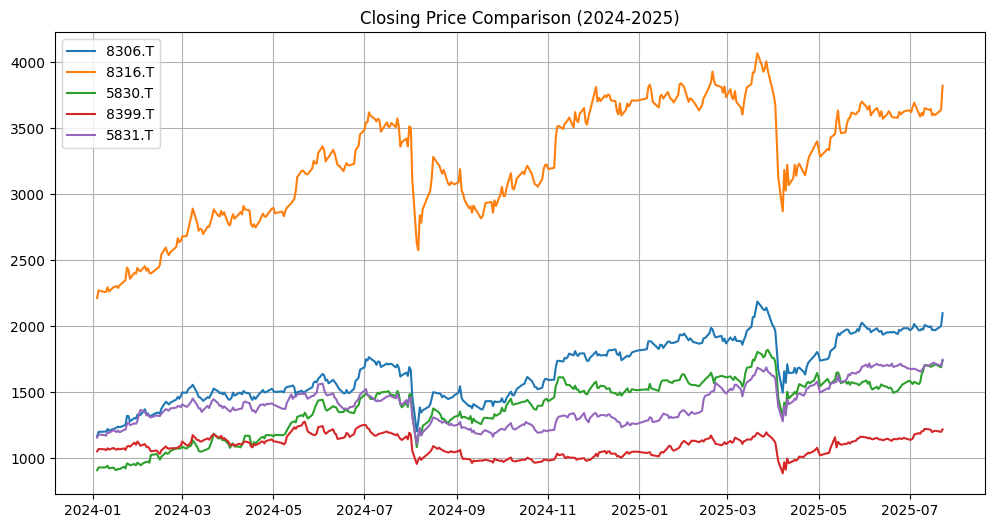

In [48]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
for symbol in jp_tickers:
    plt.plot(jp_stocks_df[symbol], label=symbol)
plt.title("Closing Price Comparison (2024-2025)")
plt.legend()
plt.grid(True)
plt.show()
# 3,7,1

In [ ]:
jp_news_df.groupby('month')['headline'].count()

month
2024-01     15
2024-02      7
2024-03    102
2024-04     39
2024-05     21
2024-06     37
2024-07     56
2024-08     57
2024-09     28
2024-10     21
2024-11      7
2024-12     19
2025-01    100
2025-02     37
2025-03     50
2025-04     29
2025-05     34
2025-06     69
2025-07     28
Name: headline, dtype: int64

In [ ]:
jp_month_intro = jp_news_df.groupby('month')['intro'].sum()

In [ ]:
!pip install openai

  Using cached anyio-4.9.0-py3-none-any.whl.metadata (4.7 kB)
  Using cached httpx-0.28.1-py3-none-any.whl.metadata (7.1 kB)
  Using cached httpcore-1.0.9-py3-none-any.whl.metadata (21 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 764.4/764.4 kB 3.0 MB/s eta 0:00:00a 0:00:01
Using cached anyio-4.9.0-py3-none-any.whl (100 kB)
Using cached httpx-0.28.1-py3-none-any.whl (73 kB)
Using cached httpcore-1.0.9-py3-none-any.whl (78 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6/6 [openai]2m5/6 [openai]e]


In [ ]:
import openai
from openai import OpenAI

client = OpenAI(api_key=API_KEY)  # OpenAI 키 입력

def summarize_text(text):
    response = client.chat.completions.create(
        model="gpt-3.5-turbo",  # 또는 gpt-3.5-turbo
        messages=[
            {"role": "system", "content": "You are a helpful assistant that summarizes news articles."},
            {"role": "user", "content": f"다음 뉴스를 세 문장으로 요약해줘:\n\n{text}"}
        ],
        temperature=0.5,
        max_tokens=300,
    )
    return response.choices[0].message.content

print(summarize_text(jp_month_intro.iloc[0]))


RateLimitError: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}

In [ ]:
jp_month_intro.iloc[0]

"The Bank of Japan's summary of last week's meeting signals it is moving closer to raising its interest rate for the first time since 2007.The present year marks the fiftieth year since a floating rate regime was adopted for the Japanese yen. The “lost decades” since the collapse of an asset...The Bank of Japan will exit its ultra-loose monetary policy once the Federal Reserve begins lowering interest rates, resulting in yen gains and higher...In an effort to stimulate a sluggish economy, the government got creative and started applying negative interest rates.TOKYO -- Interest payments on Japanese government bonds could swell to 15.3 trillion yen ($103 billion) in fiscal 2027, a roughly 60% increase from th.Japan's Bull Market Is Still Charging Ahead ... The central bank is keeping everyone guessing.Download scientific diagram | Yield curve -Japan government bonds' interest rates (average in Dec 2015, June 2016 and Dec 2016) from publication: Japan's...One in six Japanese companies ha

### Months to look into: 
Big drops: 
2024-08
2025-05

Other months: 
gradually upwards 

In [49]:
for symbol in jp_tickers:
    t = yf.Ticker(symbol)
    info = t.info
    price = info.get("currentPrice")
    eps = info.get("trailingEps")
    bps = info.get("bookValue")
    roe = info.get("returnOnEquity")

    per = price / eps if eps else None
    pbr = price / bps if bps else None

    print(f"[{symbol}]")
    print(f"PER: {per:.2f}")
    print(f"PBR: {pbr:.2f}")
    print(f"ROE: {roe:.2%}")
    print("-----------")

[8306.T]
PER: 13.33
PBR: 1.34
ROE: 6.71%
-----------
[8316.T]
PER: 12.55
PBR: 1.02
ROE: 3.52%
-----------
[5830.T]
PER: 10.05
PBR: 0.66
ROE: 6.48%
-----------
[8399.T]
PER: 8.98
PBR: 0.37
ROE: 4.07%
-----------
[5831.T]
PER: 13.28
PBR: 0.84
ROE: 6.30%
-----------
